In [1]:
import numpy as np 
from matplotlib import pyplot as plt
from jax import numpy as jnp
import jax 
import diffrax 
import optax
from jax import jit, vmap

In [2]:
import importlib
import sys
from pathlib import Path
import os 
sys.path.append(str(Path(os.getcwd()).parent / "src"))

import constriction 
importlib.reload(constriction) 
from constriction import * 

## Plot the energy landscape in $\theta, \phi$ space 

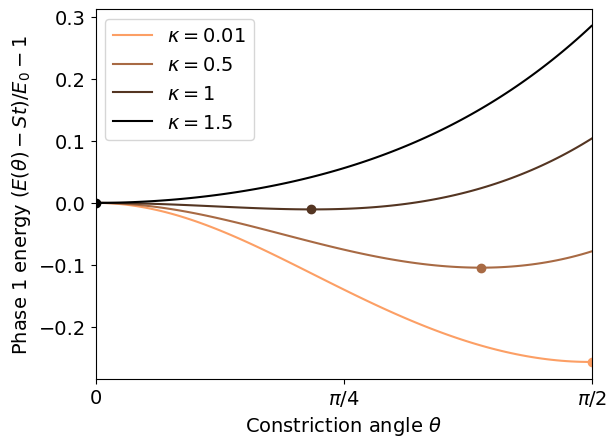

In [14]:
thetas = np.linspace(0, np.pi/2, 100)
E_jit = jit(total_energy)
E_vec = vmap(E_jit, in_axes=(0, None, None))

plt.rcParams['font.size'] = 14

k_vals = [0.01, 0.5, 1, 1.5] 

colors = plt.cm.copper_r(np.linspace(0.2, 1, len(k_vals)))

for i, k in enumerate(k_vals): 
    E_values = E_vec(thetas, np.pi/2, k)
    E_values -= E_values[0]
    plt.plot(thetas, E_values, label=rf'$\kappa={k}$', color=colors[i])
    
    # Find and mark the minimum
    min_idx = np.argmin(E_values)
    plt.plot(thetas[min_idx], E_values[min_idx], 'o', color=colors[i], markersize=6)

plt.legend() 
plt.xlim([0, np.pi/2])
plt.xticks([0, np.pi/4, np.pi/2], ['0', r'$\pi/4$', r'$\pi/2$'])
plt.xlabel(r'Constriction angle $\theta$')
plt.ylabel(r'Phase 1 energy $(E(\theta) - S t) /E_0 - 1$')
plt.savefig('../figures/energy_vs_theta.svg', dpi=300, bbox_inches='tight')
plt.show()

(200,)
(200,)
(200,)


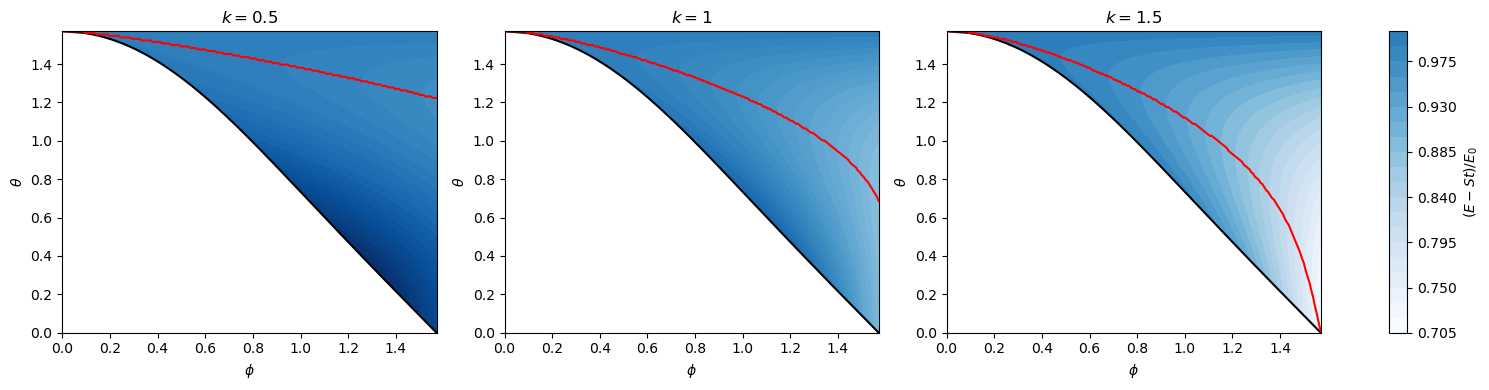

In [4]:
k_vals = [0.5, 1, 1.5]

thetas = np.linspace(0, np.pi/2, 200)
phis = np.linspace(0, np.pi/2, 200)
x, y = np.meshgrid(phis, thetas)

fig = plt.figure(figsize=(15, 4))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.05])
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cax = fig.add_subplot(gs[0, 3])

# Find global min/max for consistent colorbar
vmin = float('inf')
vmax = float('-inf')
for k in k_vals:
    energy = np.array(total_energy(y, x, k))
    energy[x < np.arccos(np.sin(y)/F(y))] = np.nan
    vmin = np.minimum(vmin, np.nanmin(energy))
    vmax = np.maximum(vmax, np.nanmax(energy))

for i, k in enumerate(k_vals):
    energy = np.array(total_energy(y, x, k))
    energy[x < np.arccos(np.sin(y)/F(y))] = np.nan
    min_indices = np.nanargmin(energy, axis=0)
    min_thetas = y[min_indices, np.arange(len(min_indices))] 

    print(min_thetas.shape)
    
    im = axes[i].contourf(x, y, energy, levels=20, cmap='Blues', vmin=vmin, vmax=vmax)
    axes[i].plot(np.arccos(np.sin(thetas)/F(thetas)), thetas, color='black')
    axes[i].plot(x[0], min_thetas, color='red')
    axes[i].set_xlabel(r'$\phi$')
    axes[i].set_ylabel(r'$\theta$')
    axes[i].set_title(rf'$k={k}$')

plt.colorbar(im, cax=cax, label=r'$(E - S t)/E_0$')
plt.tight_layout()
plt.savefig('../figures/constriction.png', dpi=300)
plt.show()



In [5]:
# Define the loss function
def loss_fn(theta, k):
    return total_energy(theta, np.pi/2, k)

# Setup optimizer
optimizer = optax.adam(learning_rate=0.005)

def find_minimum_for_k_optax(k, steps=4000):
    # Initial parameters
    theta = np.pi/4 
    opt_state = optimizer.init(theta)
    
    # One step of optimization
    @jax.jit
    def step(theta, opt_state):
        loss_value, grads = jax.value_and_grad(loss_fn)(theta, k)
        updates, opt_state = optimizer.update(grads, opt_state)
        theta = optax.apply_updates(theta, updates)
        # Clip to bounds
        theta = jnp.clip(theta, 0, jnp.pi/2)
        return theta, opt_state, loss_value

    # Optimization loop
    for _ in range(steps):
        theta, opt_state, loss_value = step(theta, opt_state)
    
    return theta, loss_value

# Run optimization
k_values= jnp.arange(0, 2, 0.01)
results = jnp.array([find_minimum_for_k_optax(k) for k in k_values])


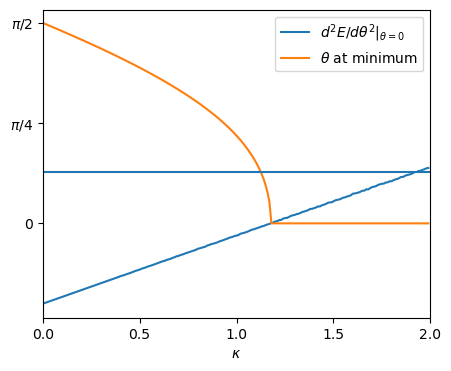

In [6]:
# JIT compile the function
ddG_jit = jit(ddG)
# Vectorize it to handle arrays
curvG_vec = vmap(ddG_jit, in_axes=(None, None, 0))
curvG_vals = curvG_vec(1e-2, np.pi/2, k_values)


fig = plt.figure(figsize=(5, 4))
plt.plot(k_values, curvG_vals, label=r'$d^2 E / d\theta^2|_{\theta = 0 }$')
plt.plot(k_values, results[:, 0], label=r'$\theta$ at minimum')
plt.xlabel(r'$\kappa$')
plt.xlim([0, 2])
plt.axhline(y=0.4) 
plt.xticks([0, 0.5, 1, 1.5, 2])
plt.yticks([0, np.pi/4, np.pi/2], ['0', r'$\pi/4$', r'$\pi/2$'])
plt.legend() 
# plt.savefig('../figures/constriction_theta.pdf')
plt.show() 

## Solve the constriction problem with dissipation 

In [7]:
# set up ode solver 
def rhs(t, theta, args):
    phi_dot = args[-1]
    return dtheta_dt(theta, phi_dot*t, args)

term = diffrax.ODETerm(rhs)
solver = diffrax.Euler()  

def solve_ode(params, dt0=0.001, y0=np.pi/2, t0=0.1, t1=10):
    saveat = diffrax.SaveAt(ts=jnp.linspace(t0, t1, 500))

    # Solve
    solution = diffrax.diffeqsolve(
        term,
        solver,
        t0=t0,
        t1=t1,
        dt0=dt0,
        y0=y0,
        args=jnp.array(params), 
        saveat=saveat,
        max_steps=int((t1-t0)/dt0*2)
    )
    return solution

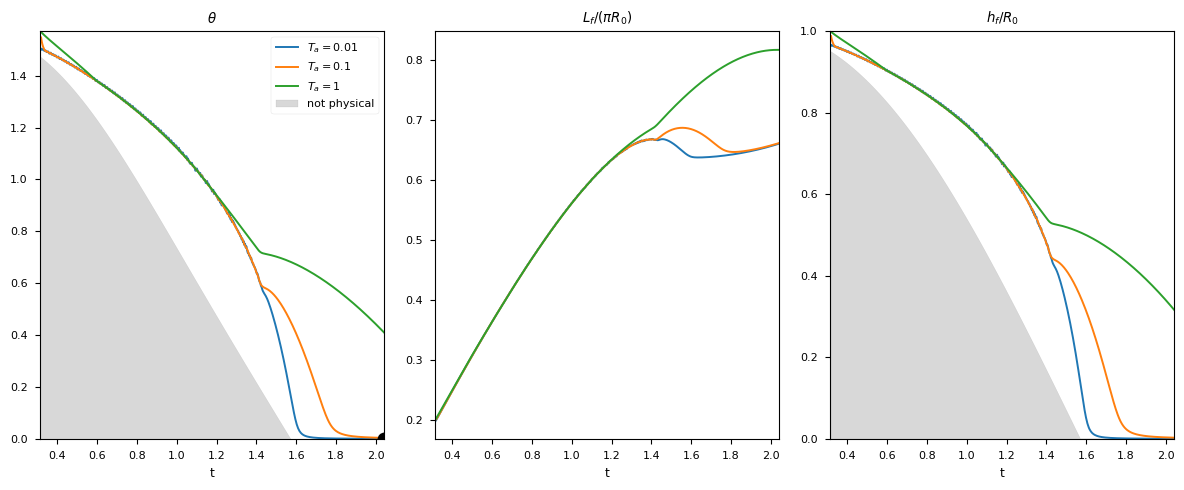

In [12]:
# Set up params 
Ta = 0.01
l = 0.01
phi_dot = 1
k = 1.5
params = [k, Ta, l, phi_dot]

# set up simulation scope
t0 = np.pi/10/phi_dot
t1 = np.maximum(np.pi/2/phi_dot*1.3, Ta*10)
dt0 = 1e-3

plt.style.use('seaborn-v0_8-paper')
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=True)

for (i, Ta) in enumerate([0.01, 0.1, 1]):
    params[1] = Ta
    solution = solve_ode(params, dt0=dt0, t0=t0, t1=t1)
    ts = solution.ts[1:]  # time points
    ys = solution.ys[1:]  # solution at each time point
    line = axes[0].plot(ts, ys, '-', label=rf'$T_a={Ta}$')
    axes[1].plot(ts, zeta(ys, phi_dot*ts), '-', label=f'k={k}')
    axes[2].plot(ts, h(ys), '-', label=f'k={k}')

axes[0].plot(ts[-1], results[int(k*100), 0], 'o', markersize=10, color='black')


thetas = np.linspace(0, np.pi/2, 100)
axes[0].fill_between(np.arccos(np.sin(thetas)/F(thetas))/phi_dot,
                     thetas, color='grey', alpha=0.3, label='not physical')
hs = np.cos(ts*phi_dot)
axes[2].fill_between(ts, hs, color='grey', alpha=0.3, label='not physical')

axes[0].legend() 
axes[0].set_xlim([t0, t1])
axes[0].set_title(r'$\theta$')
axes[0].set_ylim([0, np.pi/2])
axes[2].set_ylim([0, 1])
axes[0].set_xlabel('t')
axes[1].set_xlabel('t')
axes[2].set_xlabel('t')
axes[1].set_title(r'$L_f/(\pi R_0)$')
axes[2].set_title(r'$h_f/R_0$')
plt.tight_layout() 
# plt.savefig('../figures/dyn_constriction.pdf')
plt.show()